# Load in modules

In [1]:
from detectDesign import *

# Set parameters for the run

In [ ]:
# ======= Target Pair parameters =======
PAIR_SHARE_STRAND = True  # Checks if the pairs are on the same strand

# ======= Off-target parameters =======
INCLUDE_TARGET = True  # Include the target genome in the off-target analaysis

# Set individual off-target specficiations
HAMMING_MAX = 20  # The maximum mismatches for off-target singles, default: every PAM seen
SEED_SIZE = 8  # The seed size for

# Set proximal off-target range
PROXIMAL_FULL = 0  # 0 is full match off-targets only, 20 is maximum mismatch
PROXIMAL_SEED = 0  # 0 is full match off-targets only, 20 is maximum mismatch
PROXIMAL_MIN = 23  # Minimum distance between off-target pairs considered
PROXIMAL_MAX = 200  # Maximum distance between off-target pairs considered

SMALLSEED_MAX = 0  # Set max mismatches that can be in seed
SMALLSEED_SIZE = 5  # Set a more rigid seed size for specified needs

# ======= Output details =======
DATE = datetime.datetime.now().strftime("%D").replace('/', '-') # MM-DD-YYYY
TARGET_CSV = True
OFF_TARGET_CSV = True
previous_genome_folder = ''
total_candidate_table = []
target_col = 'Target_Guide'
full_col = 'Full_Mism'
seed_col = 'Seed_Mism'

TARGET_INPUT_FILE = './detectDesign_input.csv' # File used to set target information


# Run the pipeline 

./genomes/ontargets/MN908947.3 Severe acute respiratory syndrome coro.fasta
./genomes/ontargets/MN908947.3 Severe acute respiratory syndrome coro.fasta MN908947.3 Severe acute respiratory syndrome coro MN908947.3 Severe acute respiratory syndrome coro nan ./genomes/offtargets/


/Users/joshuarollins/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joshuarollins/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MN908947.3 Severe acute respiratory syndrome coro B_sub
Empty proximal counts 8 seed in B_sub
MN908947.3 Severe acute respiratory syndrome coro MN908947.3 Severe acute respiratory syndrome coro


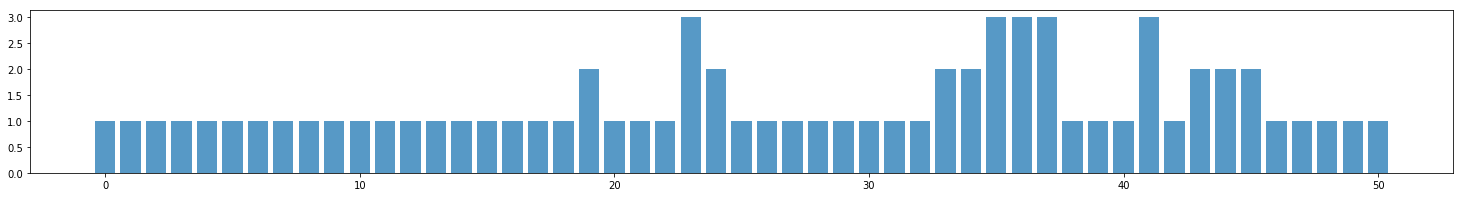

In [2]:
# Run the detectDesign_pipeline with the parameters set in the cell above
detectDesign_pipeline(PAIR_SHARE_STRAND, INCLUDE_TARGET, HAMMING_MAX, SEED_SIZE, PROXIMAL_FULL, PROXIMAL_SEED, PROXIMAL_MIN, PROXIMAL_MAX, SMALLSEED_MAX, SMALLSEED_SIZE, DATE, TARGET_CSV, OFF_TARGET_CSV, TARGET_INPUT_FILE, previous_genome_folder, total_candidate_table, target_col, full_col, seed_col)

# Optional: Pipeline code for adding in custom changes

In [ ]:
def detectDesign_pipeline(PAIR_SHARE_STRAND, INCLUDE_TARGET, HAMMING_MAX, SEED_SIZE, PROXIMAL_FULL, PROXIMAL_SEED, PROXIMAL_MIN, PROXIMAL_MAX, SMALLSEED_MAX, SMALLSEED_SIZE, DATE, TARGET_CSV, OFF_TARGET_CSV, TARGET_INPUT_FILE, previous_genome_folder, total_candidate_table, target_col, full_col, seed_col):
    target_input = pd.read_csv(TARGET_INPUT_FILE)
    for curr_target_file in set(target_input['Target_Genome']):
        print(curr_target_file)

        # Load in target genome
        target_pd = target_input[target_input['Target_Genome']
                                 == curr_target_file].reset_index()
        TARGET_NAME = target_pd['Genome_Name'][0]
        if curr_target_file.endswith('.csv'):
            target_sites = pd.read_csv(curr_target_file, index_col=0)
        else:
            target_seq = read_seq_file(curr_target_file)
            target_sites = find_guides_multiple_pams(
                target_seq, TARGET_NAME, ['NGG'])

        # Go through target input rows
        for i, row in target_pd.iterrows():
            curr_target_genome, curr_target_name, curr_name, curr_range, curr_offtarget_folder, curr_pair_range = row[
                1], row[2], row[3], row[4], row[5], row[6]
            print(
                curr_target_genome,
                curr_target_name,
                curr_name,
                curr_range,
                curr_offtarget_folder)
            
            # Load in off-target genome(s)
        if previous_genome_folder != curr_offtarget_folder:
            # Collect all the off-target genome sites
            offtarget_sites_list = [] 
            for curr_file in iglob(curr_offtarget_folder + '*'):
                curr_offtarget_name = curr_file.split('/')[-1].split('.')[-2]
                if curr_file.endswith('.csv') == True:
                    offtarget_sites = pd.read_csv(curr_file, index_col=0)
                else:
                    offtarget_seq = read_seq_file(curr_file)
                    offtarget_sites = find_guides_multiple_pams(offtarget_seq, curr_offtarget_name, ['NGG'])
                offtarget_sites_list.append(offtarget_sites)

            if INCLUDE_TARGET == True:
                offtarget_sites_list.append(target_sites)
            # Combine offtarget genome sites into one file
            offtarget_genome_sites_pd = pd.concat(offtarget_sites_list, sort=True)

            # Save name of loaded genome folder to save computation
            previous_genome_folder = curr_offtarget_folder

            # Set target region names and output folders
            if isinstance(curr_range, str):
                TARGET_REGION = literal_eval(curr_range)
            else:
                TARGET_REGION = [0, len(target_seq)]


            # Set output folder and file names
            OUTPUT_FOLDER = './results/' + curr_target_name + \
                '/' + DATE + '_' + curr_name + '_targets/'
            PREFIX = OUTPUT_FOLDER + TARGET_NAME
            AUX_FOLDER = OUTPUT_FOLDER + '/aux/'
            AUX_PREFIX = AUX_FOLDER + TARGET_NAME
            COUNTS_OUTFILE = AUX_PREFIX + '_offtargets_indv_summary_' + DATE + '.csv'
            COUNTS_PAIR_OUTFILE = AUX_PREFIX + '_offtargets_pair_summary_' + DATE + '.csv'
            COUNTS_PAIR_SUMMARY_OUTFILE = PREFIX + '_offtargets_summary_' + DATE + '.csv'
            PROXIMAL_OUTFILE = AUX_PREFIX + '_offtargets_proximal_fullmism' + \
                str(PROXIMAL_FULL) + '_seedlen' + str(SEED_SIZE) + '_seedmism_' + str(PROXIMAL_SEED) + '_' + DATE + '.csv'
            PROXIMAL_SMALLSEED_OUTFILE = AUX_PREFIX + '_offtargets_smallseed_proximal_fullmism_seedlen' + \
                str(SMALLSEED_SIZE) + '_seedmism_' + str(SMALLSEED_MAX) + '_' + DATE + '.csv'
            FIGURE_OUTFILE = AUX_PREFIX + '_pair_summary_' + DATE + '.png'
            FIGURE_SEED_OUTFILE = AUX_PREFIX + '_seed_pair_summary_' + DATE + '.png'

            # Create output folder if it doesn't exist
            if not os.path.exists(AUX_FOLDER):
                os.makedirs(AUX_FOLDER)

            if isinstance(curr_pair_range, int):
                MIN_DIST, MAX_DIST = [curr_pair_range] * 2 # Turn int into [int, int] for formatting
            else:
                # Select range of distances if exact dist not given
                MIN_DIST, MAX_DIST = literal_eval(curr_pair_range) # Turn '[int, int]' into [int, int]


            # Find all on-target sgRNA pairs
            target_sites_region = target_sites[target_sites['Start'].between(
                TARGET_REGION[0], TARGET_REGION[1])]
            candidate_table = find_target_pairs(
                target_sites_region,
                TARGET_NAME,
                MAX_DIST,
                MIN_DIST,
                TARGET_REGION,
                PAIR_SHARE_STRAND,
                TARGET_CSV,
                AUX_FOLDER)
            # If there are no candidate pairs continue
            if len(candidate_table) == 0:
                print('No candidate pairs in ' + str(curr_name))
                continue


            # Find off-targets for individual sgRNA for all genomes
            split_candidates = split_pairs(candidate_table)
            offtargets_total_pd = find_hamming(
                offtarget_genome_sites_pd,
                split_candidates.drop_duplicates('Guide'),
                HAMMING_MAX,
                SEED_SIZE,
                SEED_SIZE)
            offtargets_total_pd = offtargets_total_pd.merge(
                split_candidates[['Guide', 'index']], left_on='Target_Guide', right_on='Guide')
            offtargets_total_pd = offtargets_total_pd.rename(
                columns={'Guide_x': 'Guide', 'index': 'Pair_idx'})


            # Create summary counts
            # Get individual counts
            counts_pd = get_mism_counts(
                offtargets_total_pd, target_col, full_col, seed_col)

            # Get and sort the counts for on-target paired output and plots
            counts_pd = expand_list_to_cols(
                counts_pd, 'Seed_Mism', nan=0, fix_int=True)
            counts_pd = expand_list_to_cols(
                counts_pd, 'Full_Mism', nan=0, fix_int=True)

            # Find the columns for our given dataframe and sort it by name and
            # number
            n = pd.DataFrame(counts_pd.columns[5:], columns=['Name'])
            n['Pre'] = n['Name'].apply(lambda x: str(x).split('Mism')[0])
            n['Num'] = n['Name'].apply(lambda x: int(str(x).split('Mism')[1]))
            sorted_columns = list(counts_pd.columns[0:3]) + list(
                n.sort_values(['Pre', 'Num'], ascending=[False, True])['Name'])
            counts_pd = counts_pd[sorted_columns]
            counts_pd.to_csv(COUNTS_OUTFILE)

            x = counts_pd.groupby(['Pair_idx', 'Genome']).sum()
            y = counts_pd.groupby(['Pair_idx', 'Genome'])['Guide'].apply(
                lambda x: list(x.drop_duplicates()))
            pair_table_pd = pd.concat([y.apply(lambda x: x[0]).rename('Guide1'),
                                       y.apply(lambda x: x[1]).rename('Guide2'),
                                       x], axis=1).reset_index()
            pair_table_pd = pair_table_pd[sorted_columns[0:2] +
                                          ['Guide1', 'Guide2'] + sorted_columns[3:]]
            pair_table_pd.to_csv(COUNTS_PAIR_OUTFILE)


            # Full_Mism and Seed_Mism paired summary plots
            pair_counts_pd = pair_table_pd.reset_index()  # Reset index to undo grouping

            # Plot Full_Mism and Seed_Mism count plots for on-target pairs in each
            # genome
            for curr_genome in set(pair_counts_pd['Genome']):
                curr_pair_counts_pd = pair_counts_pd[pair_counts_pd['Genome']
                                                     == curr_genome]
                for plot_col in ['Full_Mism', 'Seed_Mism']:
                    filter_col = [
                        col for col in sorted_columns if str(col).startswith(plot_col)]
                    split_num = [x.split('Mism')[-1] for x in filter_col]
                    zipped_data = zip_values(
                        curr_pair_counts_pd[filter_col], 0, split_num)
                    curr_FIG_OUTFILE = AUX_FOLDER + plot_col + \
                        '_summary_' + str(curr_genome) + '_' + DATE + '.png'
                    side_by_side_bar(zipped_data,
                                     curr_pair_counts_pd['Pair_idx'],
                                     ticks=range(int(split_num[-1]) + 1),
                                     space=0.15)
                    plt.title(plot_col + ' in ' + curr_genome)
                    plt.ylabel('Counts')
                    plt.xlabel(plot_col)
                    plt.savefig(curr_FIG_OUTFILE, bbox_inches='tight')
                    plt.close()

            # Find off-targets filtered for pair prep
            total_proximal_pd = find_proximal_perpair(
                offtargets_total_pd[offtargets_total_pd['Seed_Mism'].le(0)], PROXIMAL_MAX, PROXIMAL_MIN)
            cols_for_drop = total_proximal_pd.columns[[('One_Hot' in x) or (
                'Unnamed' in x) or ('_y_' in x) for x in total_proximal_pd.columns]]
            total_proximal_pd = total_proximal_pd.drop(columns=cols_for_drop)
            total_proximal_pd = total_proximal_pd.drop_duplicates()
            total_proximal_pd.to_csv(PROXIMAL_OUTFILE)

            # Create proximal summary counts
            # Get the individual sgRNA proximal counts
            # Get and sort the proximal counts for on-target paired sgRNA output and plots
            # Small seed calculations
            offtargets_smallseed_total_pd = find_hamming(
                offtarget_genome_sites_pd.drop(
                    columns=['Seed_One_Hot']),
                split_candidates.drop_duplicates('Guide'),
                HAMMING_MAX,
                SMALLSEED_MAX,
                SMALLSEED_SIZE)
            offtargets_smallseed_total_pd = offtargets_smallseed_total_pd.merge(
                split_candidates[['Guide', 'index']], left_on='Target_Guide', right_on='Guide')
            offtargets_smallseed_total_pd = offtargets_smallseed_total_pd.rename(
                columns={'Guide_x': 'Guide', 'index': 'Pair_idx'})
            total_smallseed_proximal_pd = find_proximal_perpair(
                offtargets_smallseed_total_pd[offtargets_smallseed_total_pd['Seed_Mism'].le(0)], PROXIMAL_MAX, PROXIMAL_MIN)
            cols_for_drop = total_smallseed_proximal_pd.columns[[('One_Hot' in x) or (
                'Unnamed' in x) or ('_y_' in x) for x in total_smallseed_proximal_pd.columns]]
            total_smallseed_proximal_pd = total_smallseed_proximal_pd.drop(
                columns=cols_for_drop)
            total_smallseed_proximal_pd = total_smallseed_proximal_pd.drop_duplicates()
            total_smallseed_proximal_pd.to_csv(PROXIMAL_SMALLSEED_OUTFILE)

            if len(total_smallseed_proximal_pd) > 0:
                for curr_genome in set(total_smallseed_proximal_pd['Genome_1']):
                    print(curr_name, curr_genome)
                    curr_total_smallseed_proximal_pd = total_smallseed_proximal_pd[
                        total_smallseed_proximal_pd['Genome_1'] == curr_genome]

                    # If any, plot the small seed proximal matches
                    if len(curr_total_smallseed_proximal_pd) > 0:
                        # Fill any missing data with zeros, carry through filled
                        # data
                        s = curr_total_smallseed_proximal_pd.groupby(
                            ['Pair_idx_1'])
                        objects = list(s.groups.keys())
                        data_s_pd = s.count()[['Start_1']].reset_index()
                        fill_zeros_s = set(
                            objects) - set(curr_total_smallseed_proximal_pd['Pair_idx_1'])
                        zeros_s_pd = pd.DataFrame(list(
                            zip(fill_zeros_s, [0] * len(fill_zeros_s))), columns=['Pair_idx_1', 'Start_1'])
                        data_s_pd = data_s_pd.append(
                            zeros_s_pd).sort_values('Pair_idx_1')
                        # Save ordered and filled data
                        data_s = list(data_s_pd['Start_1'])
                        s_pos = np.arange(len(objects))
                        # width:s_pos/2, height:3
                        plt.figure(figsize=(len(s_pos) / 2, 3))
                        plt.bar(s_pos, data_s, align='center', alpha=0.75)
                        name_s = '\n Proximal perfect seed counts per pair in ' + str(curr_genome) + ' for ' + str(curr_name) + '\n Seed ' + str(
                            SMALLSEED_SIZE) + 'bp match: ' + str(SMALLSEED_MAX) + ', Dist: [' + str(PROXIMAL_MIN) + ',' + str(PROXIMAL_MAX) + ']'
                    else:
                        print(
                            'Empty proximal counts, small seed ' +
                            str(SMALLSEED_SIZE) +
                            ' in ' +
                            str(curr_genome))
                        continue

                    # If any, plot the large seed proximal matches
                    if len(total_proximal_pd) > 0:
                        curr_total_proximal_pd = total_proximal_pd[total_proximal_pd['Genome_1'] == curr_genome]
                        if len(curr_total_proximal_pd) > 0:
                            # Fill any missing data with zeros, carry through
                            # filled data
                            y = curr_total_proximal_pd.groupby(['Pair_idx_1'])
                            data_y_pd = y.count()[['Start_1']].reset_index()
                            fill_zeros = set(
                                objects) - set(curr_total_proximal_pd['Pair_idx_1'])
                            zeros_pd = pd.DataFrame(
                                list(zip(fill_zeros, [0] * len(fill_zeros))), columns=['Pair_idx_1', 'Start_1'])
                            data_y_pd = data_y_pd.append(
                                zeros_pd).sort_values('Pair_idx_1')
                            # Save ordered and filled data
                            data_y = list(data_y_pd['Start_1'])
                            # width:s_pos/2, height:3
                            plt.figure(figsize=(len(s_pos) / 2, 3))
                            plt.bar(s_pos, data_y, align='center', alpha=0.75)
                        else:
                            print(
                                'Empty proximal counts ' +
                                str(SEED_SIZE) +
                                ' seed in ' +
                                str(curr_genome))
                    else:
                        print(
                            'Empty proximal counts ' +
                            str(SEED_SIZE) +
                            ' seed in ' +
                            str(curr_genome))

                    plt.xticks(s_pos, objects)
                    plt.ylabel('Counts')
                    plt.xlabel('Pair idx')
                    name_y = '\n Seed ' + str(SEED_SIZE) + 'bp match: ' + str(
                        PROXIMAL_SEED) + ', Dist: [' + str(PROXIMAL_MIN) + ',' + str(PROXIMAL_MAX) + ']'
                    plt.title(name_s + name_y)
                    plt.legend([str(SMALLSEED_SIZE) + 'bp seed',
                                str(SEED_SIZE) + 'bp seed'])

                    curr_FIG_OUTFILE = OUTPUT_FOLDER + 'proximal_summary_' + \
                        str(curr_genome) + '_' + DATE + '.png'
                    plt.savefig(curr_FIG_OUTFILE, bbox_inches='tight')
                    plt.close()
            else:
                print(
                    'No off-target proximal pairs with ' +
                    str(SMALLSEED_SIZE) +
                    ' seed in ' +
                    str(curr_name))

            if len(total_smallseed_proximal_pd) > 0:
                count_fullseed = 'Prox_' + str(SEED_SIZE) + 'Seed'
                count_smallseed = 'Prox_' + str(SMALLSEED_SIZE) + 'Seed'
                counts_ss = total_smallseed_proximal_pd.groupby(
                    ['Pair_idx_1', 'Genome_1']).count()['Start_1'].reset_index()
                counts_ss.columns = ['Pair_idx', 'Genome', count_smallseed]
                pair_table_pd = pd.merge(
                    pair_table_pd, counts_ss, on=[
                        'Pair_idx', 'Genome'], how='left')
                counts_total_cols = [
                    'Pair_idx',
                    'Genome',
                    'Guide1',
                    'Guide2',
                    count_smallseed,
                    'Seed_Mism0',
                    'Seed_Mism1',
                    'Seed_Mism2']

                if len(total_proximal_pd) > 0:
                    counts = total_proximal_pd.groupby(['Pair_idx_1', 'Genome_1']).count()[
                        'Start_1'].reset_index()
                    counts.columns = ['Pair_idx', 'Genome', count_fullseed]

                    pair_table_pd = pd.merge(
                        pair_table_pd, counts, on=[
                            'Pair_idx', 'Genome'], how='left')

                    counts_total_cols = [
                        'Pair_idx',
                        'Genome',
                        'Guide1',
                        'Guide2',
                        count_smallseed,
                        count_fullseed,
                        'Seed_Mism0',
                        'Seed_Mism1',
                        'Seed_Mism2']

                counts_total_cols = counts_total_cols + \
                    list(n[n['Pre'] == 'Full_'].sort_values(['Pre', 'Num'], ascending=[False, True])['Name'])[0:3]
                pair_table_pd[counts_total_cols[4:]] = pair_table_pd[counts_total_cols[4:]].fillna(
                    0).astype(int)
                pair_table_pd[counts_total_cols].to_csv(
                    COUNTS_PAIR_SUMMARY_OUTFILE)